# Retrieve Stock Data and Save to DF

In [1]:
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf

def get_stock(ticker, start_date, end_date, s_window, l_window):
    try:
        #yf.pdr_override()
        df = yf.download(ticker, start=start_date, end=end_date,auto_adjust=False)
        #print("DF: ",df)
# can use this as well        df = web.get_data_yahoo(ticker, start=start_date, end=end_date)
        df['Return'] = df['Adj Close'].pct_change()
        df['Return'].fillna(0, inplace = True)
        df['Date'] = df.index
        df['Date'] = pd.to_datetime(df['Date'])
        df['Month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year 
        df['Day'] = df['Date'].dt.day
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            df[col] = df[col].round(2)
        df['Weekday'] = df['Date'].dt.day_name()
        df['Week_Number'] = df['Date'].dt.strftime('%U')
        df['Year_Week'] = df['Date'].dt.strftime('%Y-%U')
        df['Short_MA'] = df['Adj Close'].rolling(window=s_window, min_periods=1).mean()
        df['Long_MA'] = df['Adj Close'].rolling(window=l_window, min_periods=1).mean()        
        col_list = ['Date', 'Year', 'Month', 'Day', 'Weekday', 
                    'Week_Number', 'Year_Week', 'Open', 
                    'High', 'Low', 'Close', 'Volume', 'Adj Close',
                    'Return', 'Short_MA', 'Long_MA']
        num_lines = len(df)
        df = df[col_list]
        print('read ', num_lines, ' lines of data for ticker: ' , ticker)
        return df
    except Exception as error:
        print(error)
        return None

In [ ]:
try:
    ticker='SPY'
    input_dir = os.getcwd()
    output_file = os.path.join(input_dir, ticker + '.csv')
    df = get_stock(ticker, start_date='2000-01-01', end_date='2025-07-08', 
               s_window=14, l_window=50)
    df.to_csv(output_file, index=False)
    print('wrote ' + str(len(df)) + ' lines to file: ' + output_file)
except Exception as e:
    print(e)
    print('failed to get Yahoo stock data for ticker: ', ticker)

[*********************100%***********************]  1 of 1 completed

read  2138  lines of data for ticker:  SPY
wrote 2138 lines to file: c:\Users\aksha\Documents\BU_RISE\Final_Project\stock-data\SPY.csv



C:\Users\aksha\AppData\Local\Temp\ipykernel_20572\2458294498.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'].fillna(0, inplace = True)


In [ ]:
#psuedocode
'''
1. create ATR column
2. create SD column
3. build LSTM columnn
4. split into train and test
5. train lstm on training data for ATR and test
6. train lstm on training data for SD and test
7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)
'''

'\n1. create ATR column\n2. create SD column\n3. build LSTM columnn\n4. split into train and test\n5. train lstm on training data for ATR and test\n6. train lstm on training data for SD and test\n7. plot results and avg. returns based on decisions (buy if delta_volatility<-alpha, sell if delta_volatility>alpha)\n'

In [3]:
df_n= df.xs('SPY',axis=1,level=1) #.xs returns a cross section; selects only values within the SPY indexes at level=1
df_n.head()
#cleaned up data

Price,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,225.04,225.83,223.88,225.24,91366500,196.12
2017-01-04,225.62,226.75,225.61,226.58,78744400,197.28
2017-01-05,226.27,226.58,225.48,226.40,78379000,197.13
2017-01-06,226.53,227.75,225.90,227.21,71559900,197.83
2017-01-09,226.91,227.07,226.42,226.46,46939700,197.18


In [4]:
import math
#challenge of how to deal with missing values in time series data
#choose sliding window of length=N (could be 20?) N_lstmtraining>N_atrslidingwindow
def atr_func(d):
    running = 0
    for i in range(len(d)):
        high = d.loc[i,"High"]
        low = d.loc[i,"Low"]
        if i==0:
            running += high-low
            continue
        if i>0:
            y_close = d.loc[i,"Close"]
        
        TR = max(high-low,max(math.abs(high-y_close),math.abs(low-y_close)))
        running+=TR
    return running/len(d)

df_n['ATR'] = df_n.rolling(window=14).apply(atr_func)
df_n

IndexingError: Too many indexers

In [5]:
#define ATR columns
high = df_n["High"]
low = df_n["Low"]
close = df_n["Close"]

prev_close = close.shift(1)


tr = pd.concat([
    high - low,
    (high - prev_close).abs(),
    (low - prev_close).abs()
], axis=1).max(axis=1)

df_n["ATR"] = tr.rolling(7).mean()

C:\Users\aksha\AppData\Local\Temp\ipykernel_20572\4206602609.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR"] = tr.rolling(7).mean()


In [ ]:
import numpy as np

log_diff = np.log(df_n["Close"]/df_n["Close"].shift(1))
df_n["SD_Log_Close"] = log_diff.rolling(7).std()
df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
df_n["SD_normalized"] = (df_n["SD_Log_Close"] - df_n["SD_Log_Close"].mean())/df_n["SD_Log_Close"].std()
#xlb, xle, 

C:\Users\aksha\AppData\Local\Temp\ipykernel_20572\3540912812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["SD_Log_Close"] = log_diff.rolling(7).std()
C:\Users\aksha\AppData\Local\Temp\ipykernel_20572\3540912812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n["ATR_normalized"] = (df_n["ATR"] - df_n["ATR"].mean())/df_n["ATR"].std()
C:\Users\aksha\AppData\Local\Temp\ipykernel_20572\3540912812.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [13]:
#drop na values (first 6 rows)
df_n = df_n.dropna()
df_n = df_n.reset_index()

In [ ]:
(df_n.loc[1,"Date"] - df_n.loc[0,"Date"]).days

# log(c_n+1/c_c)

1

In [15]:
df_n["Delta_Days"] = [(df_n.loc[i,"Date"] - df_n.loc[0,"Date"]).days for i in range(len(df_n))]
#save clean data
df_n.to_csv("Clean_Data.csv")

In [56]:
#define lstm model
import torch
from torch.nn import *
import torch.nn.functional as F

class NN_LSTM(Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = LSTM(input_size=input_size,hidden_size=30)
        self.fc = Linear(30,output_size)
    def activation(self,X):
        return F.relu(X)
    def forward(self,input):
        input,_ = self.lstm(input)
        input = self.fc(input[-1,:,:])
        return input #return the last prediction
#lstm_layer = LSTM(input_size=4,hidden_size=30)

In [51]:
#define PDE loss
def PDE_loss(v_hat):
    return 0
    #use torch.autograd to get PDE loss

In [ ]:
def tt_split(df_n,vol_metric):
    train = df_n.loc[[i<=len(df_n)*4/5 for i in range(len(df_n))]]
    X_train = train[["Open","Close","High","Low"]].to_numpy()
    y_train = train[vol_metric].to_numpy()

    test = df_n.loc[[i>len(df_n)*4/5 for i in range(len(df_n))]]
    X_test = test[["Open","Close","High","Low"]].to_numpy()
    y_test = test[vol_metric].to_numpy()
    return X_train,y_train,X_test,y_test

X_train,y_train,X_test,y_test = tt_split(df_n,"ATR_normalized")

#bollinger bands
#try moving median instead of moving average
#try moving quartiles instead of std; q3-q2  *1/2
#take longer time period - five years

#lstm,cnn,and rnn cant either predict directional volatiliy for xl stocks


In [53]:
def make_seq(X_train,y_train,X_test,y_test):
    T = 30  # sequence length (window size)
    X_seq = []
    y_seq = []
    X_seq_test = []
    y_seq_test = []

    for i in range(len(X_train) - T):
        X_seq.append(X_train[i:i+T])  # shape: [T, 4] <- what is wanted in lstm
        y_seq.append(y_train[i+T])    # predict next ATR value
    for i in range(len(X_test)-T):    
        X_seq_test.append(X_test[i:i+T])
        y_seq_test.append(y_test[i+T])


    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    X_seq_test = torch.tensor(X_seq_test, dtype=torch.float32)
    y_seq_test = torch.tensor(y_seq_test, dtype=torch.float32).unsqueeze(1)
    
    return X_seq,y_seq,X_seq_test,y_seq_test
X_seq,y_seq,X_seq_test,y_seq_test = make_seq(X_train,y_train,X_test,y_test)

In [54]:
from torch.utils.data import DataLoader, TensorDataset

def create_loaders(X_seq,y_seq,X_seq_test,y_seq_test,batch_size=64):
    dataset = TensorDataset(X_seq, y_seq)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_test = TensorDataset(X_seq_test,y_seq_test)
    loader_test = DataLoader(dataset_test,batch_size=batch_size,shuffle=True)
    return loader,loader_test
loader,loader_test = create_loaders(X_seq,y_seq,X_seq_test,y_seq_test)

In [57]:
#training loop
model = NN_LSTM(input_size=4,output_size=1)
epochs = 60
optim = torch.optim.Adam(params = model.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_atr in loader:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model(input)
        #print(y_atr.shape)
        #print(out,y_atr)
        #break
        loss = crit(out,y_atr)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    #break
    running_loss/=(len(loader))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_atr_test in loader_test:
            out_test = model(x_window_test.permute(1,0,2))
            #print(y_atr_test.shape)
            loss = crit(out_test,y_atr_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test)))


Training Loss: 0.9418861799769931
Training Loss: 0.7981705323413566
Training Loss: 0.7739914026525285
Training Loss: 0.7952007872086985
Training Loss: 0.7819742714917218
Training Loss: 0.7680159442954593
Training Loss: 0.7721996572282579
Training Loss: 0.7816625425109157
Training Loss: 0.8293470652015121
Training Loss: 0.7768568617326242
Training Loss: 0.7776934824607991
Training Loss: 0.7701546141394863
Training Loss: 0.781218593871152
Training Loss: 0.80514446121675
Training Loss: 0.7741655740473006
Training Loss: 0.7983251324406376
Training Loss: 0.7873062888781229
Training Loss: 0.7619368665748172
Training Loss: 0.7586631178855896
Training Loss: 0.7624113261699677
Training Loss: 0.7134435154773571
Training Loss: 0.6966529687245687
Training Loss: 0.6915229007049843
Training Loss: 0.6921110053857168
Training Loss: 0.6970583465364244
Training Loss: 0.6489901299829837
Training Loss: 0.6511666134551719
Training Loss: 0.6332513601691635
Training Loss: 0.6470045138288427
Training Loss: 0.

Text(0.5, 1.0, 'Training Loss of LSTM (ATR_normalized) across 60 epochs')

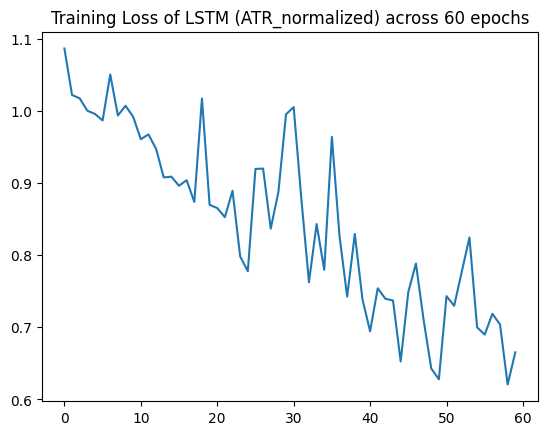

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=[i for i in range(len(losses))],y=losses)
plt.title("Training Loss of LSTM (ATR_normalized) across 60 epochs")

Text(0.5, 1.0, 'Testing Loss of LSTM (ATR_normalized) across 60 epochs')

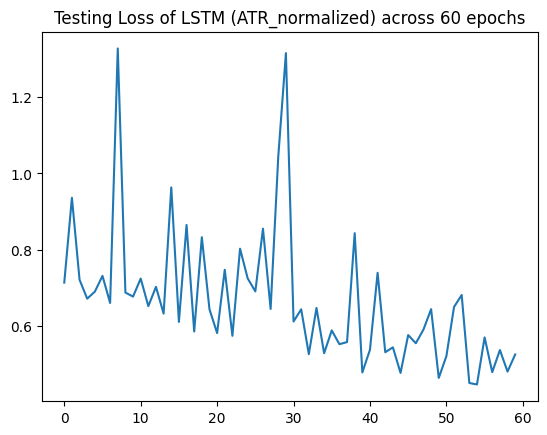

In [67]:
sns.lineplot(losses_test)
plt.title("Testing Loss of LSTM (ATR_normalized) across 60 epochs")

In [61]:
X_train_sd,y_train_sd,X_test_sd,y_test_sd = tt_split(df_n,vol_metric="SD_normalized")
X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd = make_seq(X_train_sd,y_train_sd,X_test_sd,y_test_sd)
loader_sd,loader_test_sd = create_loaders(X_seq_sd,y_seq_sd,X_seq_test_sd,y_seq_test_sd)

In [62]:
#training loop
model_sd = NN_LSTM(input_size=4,output_size=1)
epochs = 60
optim = torch.optim.Adam(params = model_sd.parameters())
crit = MSELoss()
losses = []
losses_test = []

for i in range(epochs):
    running_loss = 0
    for x_window,y_sd in loader_sd:
        #print("Running")
        input = x_window.permute(1,0,2) #shape = [seq_length,batch_length,4]
        out = model_sd(input)
        #print(y_sd.shape)
        loss = crit(out,y_sd)
        running_loss+=loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
            # could try loss += (i+1)/period/sum(j/period for j in range(period))crit(out,y_train[i]); adds a coeff to give more weigt to recent ones
    running_loss/=(len(loader_sd))
    print(f"Training Loss: {running_loss}")
    losses.append(running_loss)

    with torch.no_grad():
        testing_loss = 0
        for x_window_test,y_sd_test in loader_test_sd:
            out_test = model_sd(x_window_test.permute(1,0,2))
            #print(y_sd_test.shape)
            loss = crit(out_test,y_sd_test)
            testing_loss+=loss.item()
        losses_test.append(testing_loss/(len(loader_test_sd)))


Training Loss: 1.0867622439508084
Training Loss: 1.0222695922410046
Training Loss: 1.0176163404076188
Training Loss: 1.0004483273735754
Training Loss: 0.9959788112728684
Training Loss: 0.9868934938201198
Training Loss: 1.050672443928542
Training Loss: 0.9938115422372464
Training Loss: 1.0072634794093944
Training Loss: 0.9919067047260426
Training Loss: 0.9609342018763224
Training Loss: 0.9675465998826204
Training Loss: 0.9474563201268514
Training Loss: 0.9078993769707503
Training Loss: 0.9089176312640861
Training Loss: 0.8963312893002121
Training Loss: 0.9040890402264066
Training Loss: 0.8738630921752365
Training Loss: 1.017387212978469
Training Loss: 0.8699218818434963
Training Loss: 0.8653944178863808
Training Loss: 0.8528284198708005
Training Loss: 0.8893383548215583
Training Loss: 0.7983670411286531
Training Loss: 0.7777443771009092
Training Loss: 0.9196745389037662
Training Loss: 0.9201758945429767
Training Loss: 0.8369298798066599
Training Loss: 0.8875430049719634
Training Loss: 0

Text(0.5, 1.0, 'Training Loss of LSTM (SD__normalized) across 60 epochs')

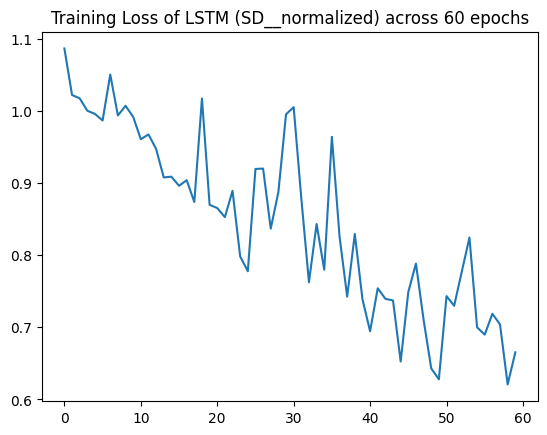

In [68]:
sns.lineplot(losses)
plt.title("Training Loss of LSTM (SD__normalized) across 60 epochs")

Text(0.5, 1.0, 'Testing Loss of LSTM (SD_normalized) across 60 epochs')

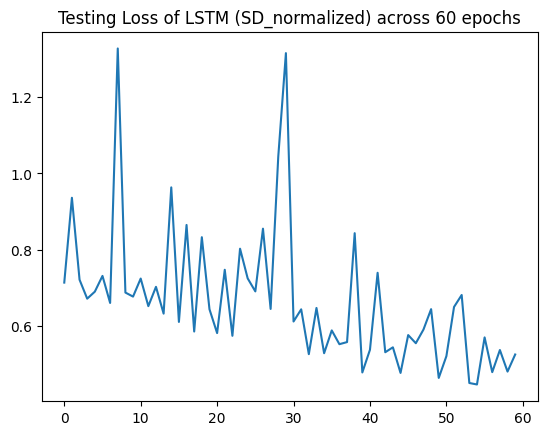

In [69]:
sns.lineplot(losses_test)
plt.title("Testing Loss of LSTM (SD_normalized) across 60 epochs")

In [65]:
#use past atrs
#try transformations of atr log(atr)